# Analysis of movie budget relative to primary outcomes: Movie Ratings, Gross Revenue

Importing packages and reading in data

In [1]:
#importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from sklearn.metrics import r2_score
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#file paths for importing data
#NOTE that some unzipped files are too large for the github repo and must be extracted locally before analysis can be performed
movie_budget_file_path = '~/Documents/Flatiron/phase_1/Movie_Studio_DATA/tn.movie_budgets.csv.gz'
microsoft_movie_studio_db_file_path = './../../Movie_Studio_DATA/im.db'
msms_db_conn = sqlite3.connect(microsoft_movie_studio_db_file_path)

In [3]:
#reading in movie budget csv for outcome data
movie_budget_df = pd.read_csv(movie_budget_file_path)
#check to see if read properly
movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
#execute SQL query to obtain a dataframe with movie names and avg ratings, filtered for original titles
avg_ratings_query = """
SELECT movie_basics.primary_title, movie_ratings.*
FROM movie_basics
INNER JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id 
INNER JOIN movie_akas ON movie_ratings.movie_id = movie_akas.movie_id
WHERE is_original_title != 0.0
"""

microsoft_movie_studio_avg_ratings = pd.read_sql(avg_ratings_query, msms_db_conn)

#check query results
microsoft_movie_studio_avg_ratings

,primary_title,movie_id,averagerating,numvotes
0,Jurassic World,tt0369610,7.00000,539338
1,John Carter,tt0401729,6.60000,241792
2,Versailles Rediscovered - The Sun King's Vanis...,tt10010134,7.00000,5
3,Alice in Wonderland,tt1014759,6.50000,358813
4,From Paris with Love,tt1179034,6.50000,107079
...,...,...,...,...
36890,Der Atem,tt9644084,5.20000,5
36891,Homing,tt9657946,6.00000,16
36892,Anderswo. Allein in Afrika,tt9723084,6.70000,35
36893,Monkey King: The Volcano,tt9726638,6.00000,6


Below are some descriptive methods used to determine what is necessary to clean this dataset for final analysis

In [5]:
microsoft_movie_studio_avg_ratings.describe()

,averagerating,numvotes
count,36895.00000,36895.00000
mean,6.17388,6956.44914
std,1.33796,42522.34756
min,1.00000,5.00000
25%,5.40000,37.00000
50%,6.30000,185.00000
75%,7.10000,1032.00000
max,10.00000,1841066.00000


In [6]:
movie_budget_df.describe()

,id
count,5782.00000
mean,50.37236
std,28.82108
min,1.00000
25%,25.00000
50%,50.00000
75%,75.00000
max,100.00000


In [7]:
microsoft_movie_studio_avg_ratings["primary_title"].value_counts()

Together                  7
Home                      7
Paradise                  7
Brothers                  6
Gold                      6
                         ..
Oddball                   1
Shake Rattle & Roll XV    1
Super Furball             1
Spirit                    1
iSteve                    1
Name: primary_title, Length: 35419, dtype: int64

Begin Data Cleaning:

In [8]:
#attempt to merge dataframes along movie titles. Inner merge will produce a dataframe that only includes movies for which a complete dataset is available.
movie_rating_budget_df = pd.merge(microsoft_movie_studio_avg_ratings, movie_budget_df, how='inner', left_on='primary_title', right_on='movie' )

In [9]:
movie_rating_budget_df 
#note the presence of a non-null-type null value in row 3 for gross sales. 
#These, and similar data, must be identified and dropped from the dataset after conversion to a numeric value.

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Jurassic World,tt0369610,7.00000,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"
1,John Carter,tt0401729,6.60000,241792,14,"Mar 9, 2012",John Carter,"$275,000,000","$73,058,679","$282,778,100"
2,Alice in Wonderland,tt1014759,6.50000,358813,51,"Mar 5, 2010",Alice in Wonderland,"$200,000,000","$334,191,110","$1,025,491,110"
3,Alice in Wonderland,tt1014759,6.50000,358813,60,"Jul 28, 1951",Alice in Wonderland,"$3,000,000",$0,$0
4,The Bourne Legacy,tt1194173,6.70000,268678,76,"Aug 10, 2012",The Bourne Legacy,"$125,000,000","$113,203,870","$280,355,920"
...,...,...,...,...,...,...,...,...,...,...
2317,Thoroughbreds,tt5649108,6.70000,25098,47,"Mar 9, 2018",Thoroughbreds,"$5,000,000","$3,072,605","$3,187,302"
2318,Aladdin,tt6139732,7.40000,57549,81,"May 24, 2019",Aladdin,"$182,000,000","$246,734,314","$619,234,314"
2319,Aladdin,tt6139732,7.40000,57549,33,"Nov 11, 1992",Aladdin,"$28,000,000","$217,350,219","$504,050,219"
2320,November,tt6164502,7.20000,2455,81,"Jul 22, 2005",November,"$250,000","$191,862","$191,862"


In [10]:
#Identified a number of duplicate entries
movie_rating_budget_df["primary_title"].value_counts()

Home                                  21
Brothers                              12
Crossroads                             6
Hamlet                                 6
Robin Hood                             6
                                      ..
Popstar: Never Stop Never Stopping     1
Safe Haven                             1
Alien Uprising                         1
Closure                                1
ParaNorman                             1
Name: primary_title, Length: 1943, dtype: int64

In [11]:
#Removing duplicate entries
movie_rating_budget_df.drop_duplicates(subset="primary_title", inplace=True)

In [12]:
#evaluating clean dataset
movie_rating_budget_df

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Jurassic World,tt0369610,7.00000,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"
1,John Carter,tt0401729,6.60000,241792,14,"Mar 9, 2012",John Carter,"$275,000,000","$73,058,679","$282,778,100"
2,Alice in Wonderland,tt1014759,6.50000,358813,51,"Mar 5, 2010",Alice in Wonderland,"$200,000,000","$334,191,110","$1,025,491,110"
4,The Bourne Legacy,tt1194173,6.70000,268678,76,"Aug 10, 2012",The Bourne Legacy,"$125,000,000","$113,203,870","$280,355,920"
5,Limitless,tt1219289,7.40000,492490,91,"Mar 18, 2011",Limitless,"$27,000,000","$79,249,455","$155,564,919"
...,...,...,...,...,...,...,...,...,...,...
2316,The Big Sick,tt5462602,7.60000,104008,64,"Jun 23, 2017",The Big Sick,"$5,000,000","$42,872,467","$53,972,860"
2317,Thoroughbreds,tt5649108,6.70000,25098,47,"Mar 9, 2018",Thoroughbreds,"$5,000,000","$3,072,605","$3,187,302"
2318,Aladdin,tt6139732,7.40000,57549,81,"May 24, 2019",Aladdin,"$182,000,000","$246,734,314","$619,234,314"
2320,November,tt6164502,7.20000,2455,81,"Jul 22, 2005",November,"$250,000","$191,862","$191,862"


In [13]:
movie_rating_budget_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1943 entries, 0 to 2321
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      1943 non-null   object 
 1   movie_id           1943 non-null   object 
 2   averagerating      1943 non-null   float64
 3   numvotes           1943 non-null   int64  
 4   id                 1943 non-null   int64  
 5   release_date       1943 non-null   object 
 6   movie              1943 non-null   object 
 7   production_budget  1943 non-null   object 
 8   domestic_gross     1943 non-null   object 
 9   worldwide_gross    1943 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 167.0+ KB


In [14]:
movie_rating_budget_df.describe()

,averagerating,numvotes,id
count,1943.00000,1943.00000,1943.00000
mean,6.23258,90783.79619,50.69532
std,1.09151,150704.05473,28.55909
min,1.60000,5.00000,1.00000
25%,5.60000,3112.00000,26.00000
50%,6.30000,34759.00000,51.00000
75%,7.00000,108474.00000,75.00000
max,9.00000,1841066.00000,100.00000


For the final analysis, gross revenues and budget values need to be converted to numeric data types. This will allow us to calculate the net profits for each movie in our dataset, as well as address some non-null-type null values identified earlier in the cleaning process. 

To control for the wide time range that this dataset covers, net profits will be evaluated as a percentage of the movie budget, and identified as "return on investment".

In [15]:
#removing special characters from columns for conversion to numeric data type
movie_rating_budget_df['production_budget'] = movie_rating_budget_df['production_budget'].replace(",","",regex=True)
movie_rating_budget_df['production_budget'] = movie_rating_budget_df['production_budget'].str.replace("$","",regex=True)

movie_rating_budget_df['domestic_gross'] = movie_rating_budget_df['domestic_gross'].replace(",","",regex=True)
movie_rating_budget_df['domestic_gross'] = movie_rating_budget_df['domestic_gross'].str.replace("$","",regex=True)

movie_rating_budget_df['worldwide_gross'] = movie_rating_budget_df['worldwide_gross'].replace(",","",regex=True)
movie_rating_budget_df['worldwide_gross'] = movie_rating_budget_df['worldwide_gross'].str.replace("$","",regex=True)

#check replacement
movie_rating_budget_df.head()

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Jurassic World,tt0369610,7.00000,539338,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864
1,John Carter,tt0401729,6.60000,241792,14,"Mar 9, 2012",John Carter,275000000,73058679,282778100
2,Alice in Wonderland,tt1014759,6.50000,358813,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110
4,The Bourne Legacy,tt1194173,6.70000,268678,76,"Aug 10, 2012",The Bourne Legacy,125000000,113203870,280355920
5,Limitless,tt1219289,7.40000,492490,91,"Mar 18, 2011",Limitless,27000000,79249455,155564919


In [16]:
#convert money columns to floating point values
movie_rating_budget_df['production_budget'] = movie_rating_budget_df['production_budget'].astype(float)
movie_rating_budget_df['domestic_gross'] = movie_rating_budget_df['domestic_gross'].astype(float)
movie_rating_budget_df['worldwide_gross'] = movie_rating_budget_df['worldwide_gross'].astype(float)

In [17]:
#remove rows with non-null-type null values
movie_rating_budget_df = movie_rating_budget_df[movie_rating_budget_df['production_budget'] != 0] 
movie_rating_budget_df = movie_rating_budget_df[movie_rating_budget_df['domestic_gross'] != 0]
movie_rating_budget_df = movie_rating_budget_df[movie_rating_budget_df['worldwide_gross'] != 0]

In [18]:
#check results
movie_rating_budget_df.describe()

,averagerating,numvotes,id,production_budget,domestic_gross,worldwide_gross
count,1704.00000,1704.00000,1704.00000,1704.00000,1704.00000,1704.00000
mean,6.36461,102549.03756,50.62911,43187199.97418,54554627.56984,134119225.79988
std,0.98935,157231.88006,28.46895,54121990.42718,82441792.42829,230174484.61203
min,1.60000,5.00000,1.00000,9000.00000,388.00000,528.00000
25%,5.80000,7578.00000,26.00000,8500000.00000,5077831.50000,10346676.00000
50%,6.40000,45807.00000,50.00000,24000000.00000,27330498.50000,49768433.00000
75%,7.10000,123587.50000,75.00000,52125000.00000,64665173.00000,148273302.00000
max,9.00000,1841066.00000,100.00000,425000000.00000,760507625.00000,2776345279.00000


In [19]:
#return on investment
movie_rating_budget_df["total_return_on_investment"] = movie_rating_budget_df["worldwide_gross"]/movie_rating_budget_df["production_budget"]
movie_rating_budget_df["domestic_return_on_investment"] = movie_rating_budget_df["domestic_gross"]/movie_rating_budget_df["production_budget"]
#check table results
movie_rating_budget_df

,primary_title,movie_id,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_return_on_investment,domestic_return_on_investment
0,Jurassic World,tt0369610,7.00000,539338,34,"Jun 12, 2015",Jurassic World,215000000.00000,652270625.00000,1648854864.00000,7.66909,3.03382
1,John Carter,tt0401729,6.60000,241792,14,"Mar 9, 2012",John Carter,275000000.00000,73058679.00000,282778100.00000,1.02828,0.26567
2,Alice in Wonderland,tt1014759,6.50000,358813,51,"Mar 5, 2010",Alice in Wonderland,200000000.00000,334191110.00000,1025491110.00000,5.12746,1.67096
4,The Bourne Legacy,tt1194173,6.70000,268678,76,"Aug 10, 2012",The Bourne Legacy,125000000.00000,113203870.00000,280355920.00000,2.24285,0.90563
5,Limitless,tt1219289,7.40000,492490,91,"Mar 18, 2011",Limitless,27000000.00000,79249455.00000,155564919.00000,5.76166,2.93517
...,...,...,...,...,...,...,...,...,...,...,...,...
2316,The Big Sick,tt5462602,7.60000,104008,64,"Jun 23, 2017",The Big Sick,5000000.00000,42872467.00000,53972860.00000,10.79457,8.57449
2317,Thoroughbreds,tt5649108,6.70000,25098,47,"Mar 9, 2018",Thoroughbreds,5000000.00000,3072605.00000,3187302.00000,0.63746,0.61452
2318,Aladdin,tt6139732,7.40000,57549,81,"May 24, 2019",Aladdin,182000000.00000,246734314.00000,619234314.00000,3.40239,1.35568
2320,November,tt6164502,7.20000,2455,81,"Jul 22, 2005",November,250000.00000,191862.00000,191862.00000,0.76745,0.76745


In [20]:
movie_rating_budget_df.describe()

,averagerating,numvotes,id,production_budget,domestic_gross,worldwide_gross,total_return_on_investment,domestic_return_on_investment
count,1704.00000,1704.00000,1704.00000,1704.00000,1704.00000,1704.00000,1704.00000,1704.00000
mean,6.36461,102549.03756,50.62911,43187199.97418,54554627.56984,134119225.79988,4.10426,2.15878
std,0.98935,157231.88006,28.46895,54121990.42718,82441792.42829,230174484.61203,14.09091,7.51681
min,1.60000,5.00000,1.00000,9000.00000,388.00000,528.00000,0.00014,0.00003
25%,5.80000,7578.00000,26.00000,8500000.00000,5077831.50000,10346676.00000,0.85782,0.39366
50%,6.40000,45807.00000,50.00000,24000000.00000,27330498.50000,49768433.00000,2.17566,0.96369
75%,7.10000,123587.50000,75.00000,52125000.00000,64665173.00000,148273302.00000,4.07217,2.08901
max,9.00000,1841066.00000,100.00000,425000000.00000,760507625.00000,2776345279.00000,416.56474,227.64410


# Visualizations and Export

0.015579476932341407


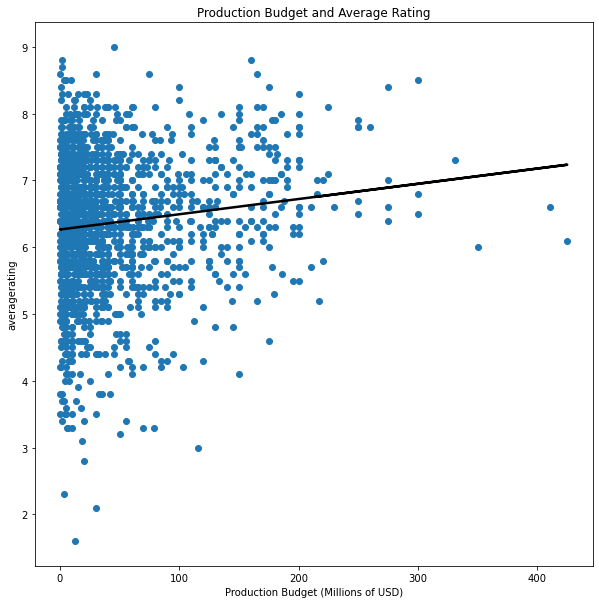

In [21]:
#scatter plot of budget(x) rating(y)
fig,ax = plt.subplots(figsize=(10,10))
x = movie_rating_budget_df["production_budget"]/1000000
y = movie_rating_budget_df["averagerating"]
ax.scatter(x,y)
ax.set_title("Production Budget and Average Rating")
ax.set_xlabel("Production Budget (Millions of USD)")
ax.set_ylabel("averagerating")
plt.ticklabel_format(style='plain')
#regression
m, b = np.polyfit(x,y, deg=1)
dist = np.linspace
ax.plot(x, m*x+b, color="k", lw=2.5);

#R^2 correlation metric
R2 = r2_score(y, m*x+b)
print(R2)

0.613785886022603


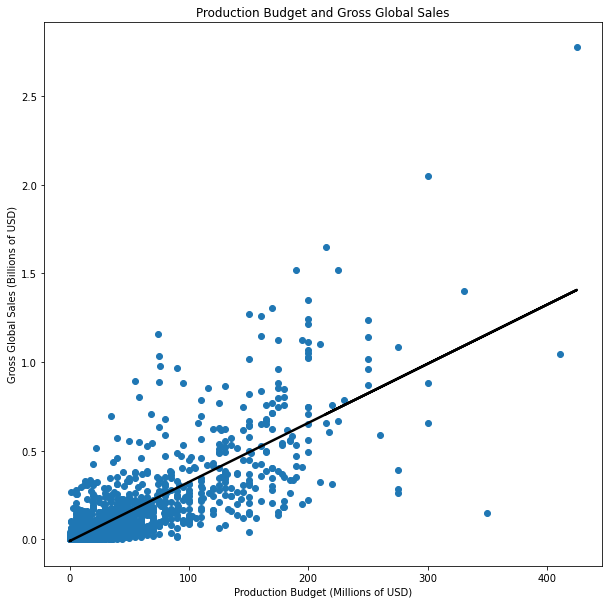

In [22]:
#scatter plot of budget(x) gross sales(y)
fig,ax = plt.subplots(figsize=(10,10))
x = movie_rating_budget_df["production_budget"]/1000000
y = movie_rating_budget_df["worldwide_gross"]/1000000000
ax.scatter(x,y)
ax.set_title("Production Budget and Gross Global Sales")
ax.set_xlabel("Production Budget (Millions of USD)")
ax.set_ylabel("Gross Global Sales (Billions of USD)")
plt.ticklabel_format(style='plain')
#regression
m, b = np.polyfit(x,y, deg=1)
dist = np.linspace
ax.plot(x, m*x+b, color="k", lw=2.5);

#R^2 correlation metric
R2 = r2_score(y,m*x+b)
print(R2)

0.0032025216448912097


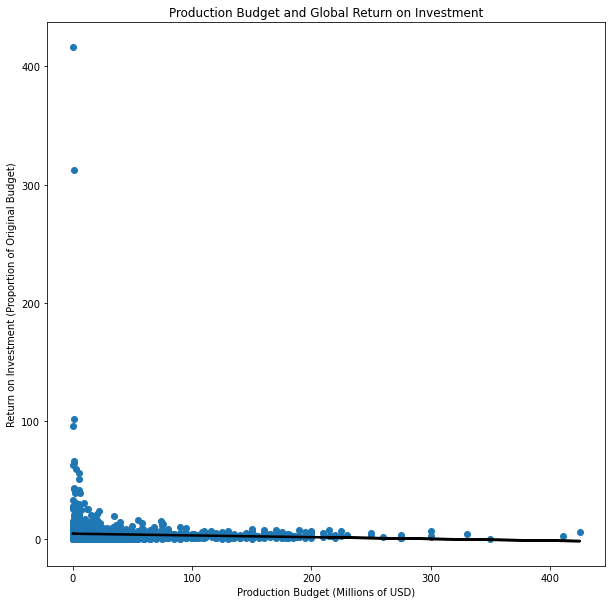

In [23]:
#scatter plot of budget(x) return on investment(y)
fig,ax = plt.subplots(figsize=(10,10))
x = movie_rating_budget_df["production_budget"]/1000000
y = movie_rating_budget_df["total_return_on_investment"]
ax.scatter(x,y)
ax.set_title("Production Budget and Global Return on Investment")
ax.set_xlabel("Production Budget (Millions of USD)")
ax.set_ylabel("Return on Investment (Proportion of Original Budget)")
plt.ticklabel_format(style='plain')
#regression
m, b = np.polyfit(x,y, deg=1)
dist = np.linspace
ax.plot(x, m*x+b, color="k", lw=2.5);

#R^2 correlation metric
R2 = r2_score(y,m*x+b)
print(R2)

0.4377091490124818


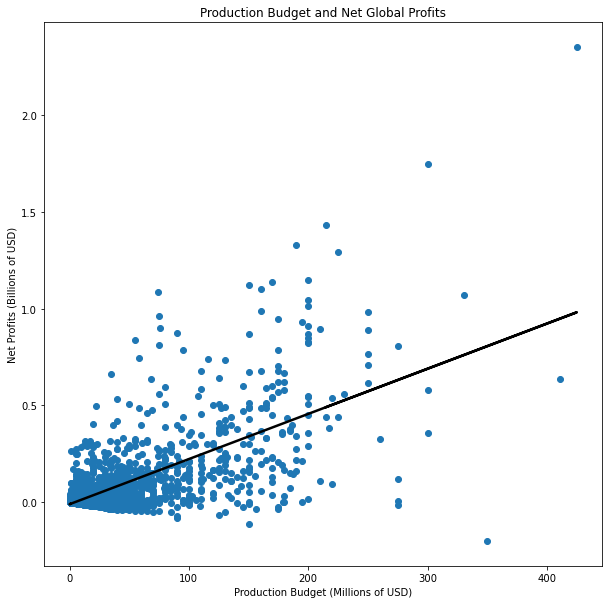

In [24]:
#scatter plot of budget(x) gross sales(y)
fig,ax = plt.subplots(figsize=(10,10))
x = movie_rating_budget_df["production_budget"]/1000000
y = (movie_rating_budget_df["worldwide_gross"] - movie_rating_budget_df["production_budget"])/1000000000
ax.scatter(x,y)
ax.set_title("Production Budget and Net Global Profits")
ax.set_xlabel("Production Budget (Millions of USD)")
ax.set_ylabel("Net Profits (Billions of USD)")
plt.ticklabel_format(style='plain')
#regression
m, b = np.polyfit(x,y, deg=1)
dist = np.linspace
ax.plot(x, m*x+b, color="k", lw=2.5);

#R^2 correlation metric
R2 = r2_score(y,m*x+b)
print(R2)

0.04284030040880471


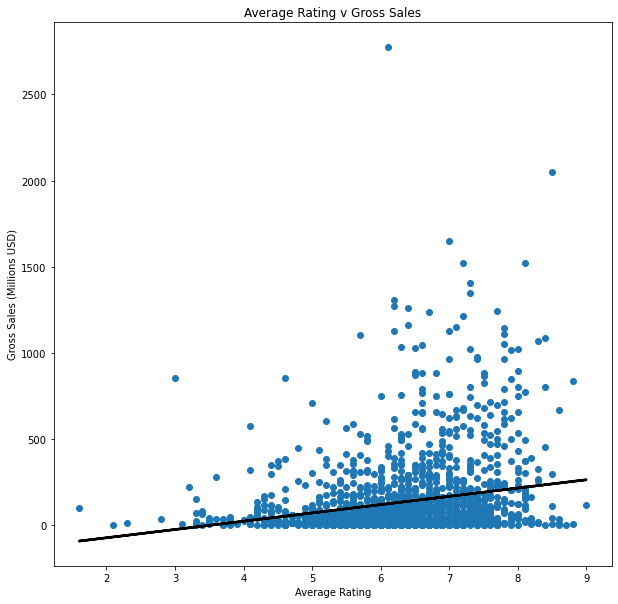

In [25]:
#scatter plot of rating(x) gross profits(y)
fig,ax = plt.subplots(figsize=(10,10))
x = movie_rating_budget_df["averagerating"]
y = movie_rating_budget_df["worldwide_gross"]/1000000
ax.scatter(x,y)
ax.set_title("Average Rating v Gross Sales")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Gross Sales (Millions USD)")
plt.ticklabel_format(style='plain')
#regression
m, b = np.polyfit(x,y, deg=1)
dist = np.linspace
ax.plot(x, m*x+b, color="k", lw=2.5);

#R^2 correlation metric
R2 = r2_score(y, m*x+b)
print(R2)